In [ ]:
import pandas as pd
import numpy as np
from keras import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
%matplotlib inline

In [7]:
df = pd.read_csv('spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


**Preprocessing**

In [8]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Number of ham and spam messages')

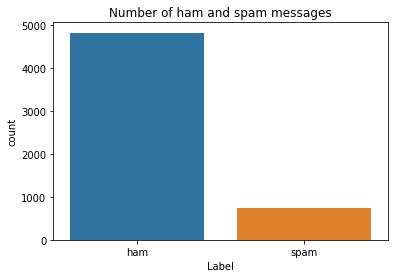

In [9]:
sns.countplot(df.v1)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [10]:
X = df.v2
Y = df.v1
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [11]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.15)

In [12]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = utils.pad_sequences(sequences,maxlen=max_len)

In [13]:
sequences_matrix.shape

(4736, 150)

In [14]:
sequences_matrix.ndim

2

In [15]:
sequences_matrix = np.reshape(sequences_matrix,(4736,150,1))

In [16]:
sequences_matrix.ndim #3d shape verification to proceed to RNN LSTM

3

**RNN Construction**

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

In [18]:
model = Sequential()
model.add(Embedding(max_words,50,input_length=max_len))

In [19]:
model.add(LSTM(units=64,input_shape = (sequences_matrix.shape[1],1),return_sequences=True))
model.add(LSTM(units=64,return_sequences=True))
model.add(LSTM(units=64,return_sequences=True))
model.add(LSTM(units=64))
model.add(Dense(units = 256,activation = 'relu'))
model.add(Dense(units = 1,activation = 'sigmoid'))

In [20]:
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 150, 64)           29440     
                                                                 
 lstm_1 (LSTM)               (None, 150, 64)           33024     
                                                                 
 lstm_2 (LSTM)               (None, 150, 64)           33024     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dense_1 (Dense)             (None, 1)                 2

**Fit on the training data**

In [21]:
M = model.fit(sequences_matrix,Y_train,batch_size=128,epochs=5,validation_split=0.2)

Epoch 1/5
30/30 [==============================] - 45s 1s/step - loss: 0.3141 - accuracy: 0.9015 - val_loss: 0.1514 - val_accuracy: 0.9578
Epoch 2/5
30/30 [==============================] - 35s 1s/step - loss: 0.0869 - accuracy: 0.9744 - val_loss: 0.1000 - val_accuracy: 0.9705
Epoch 3/5
30/30 [==============================] - 33s 1s/step - loss: 0.0531 - accuracy: 0.9857 - val_loss: 0.0865 - val_accuracy: 0.9800
Epoch 4/5
30/30 [==============================] - 34s 1s/step - loss: 0.0419 - accuracy: 0.9886 - val_loss: 0.0775 - val_accuracy: 0.9800
Epoch 5/5
30/30 [==============================] - 33s 1s/step - loss: 0.0311 - accuracy: 0.9918 - val_loss: 0.0941 - val_accuracy: 0.9778


**Saving the model**

In [22]:
model.save

<bound method Model.save of <keras.engine.sequential.Sequential object at 0x7fc298fee050>>

**Evaluate the model on test set data**

In [23]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = utils.pad_sequences(test_sequences,maxlen=max_len)

In [24]:
accr = model.evaluate(test_sequences_matrix,Y_test)

27/27 [==============================] - 4s 94ms/step - loss: 0.0940 - accuracy: 0.9821


In [25]:
l = accr[0]
a =accr[1]
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(l,a))

Test set
  Loss: 0.094
  Accuracy: 0.982


**Accuracy and Loss Graph**

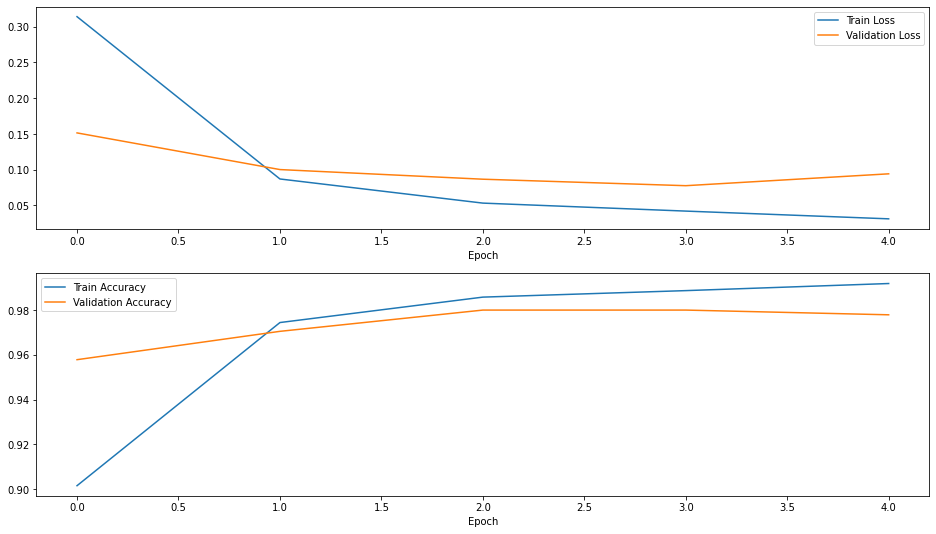

In [26]:
results = pd.DataFrame({"Train Loss": M.history['loss'], "Validation Loss": M.history['val_loss'],
              "Train Accuracy": M.history['accuracy'], "Validation Accuracy": M.history['val_accuracy']
             })
fig, ax = plt.subplots(nrows=2, figsize=(16, 9))
results[["Train Loss", "Validation Loss"]].plot(ax=ax[0])
results[["Train Accuracy", "Validation Accuracy"]].plot(ax=ax[1])
ax[0].set_xlabel("Epoch")
ax[1].set_xlabel("Epoch")
plt.show()